# Problema 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%run lib.ipynb
%matplotlib inline

In [3]:
alpha = np.pi*np.array([1.0/6,0.1])
g = 9.81

In [4]:
def ec_mov(r_v, t, fric = 0., g = 9.81, m = 1.):
    """
    r_v contiene
    """
    u = sqrt(r_v[2]**2 + r_v[3]**2)
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0.:
        dvx = 0.
        dvy = -g/m
    else:
        dvx = -fric([r_v[2], r_v[3]])[0]
        dvy = -g/m -fric([r_v[2], r_v[3]])[1]
    return array([dx,dy,dvx,dvy])
def fricV2(v, gamma = 0.05):
    norma = sqrt(v[0]**2+v[1]**2)
    f_x = gamma*norma*v[0]
    f_y = gamma*norma*v[1]
    return array([f_x,f_y])

In [5]:
def rampa(x,alpha):
    return np.array(np.abs(x)*np.tan(alpha),np.float16)

In [6]:
def rebote_rampa(r_v_i,mi_dt,alpha,tol=1e-2,**kwargs):
    dt_busqueda = mi_dt/2
    y0 = r_v_i
    t,sol = int_rk4(ec_mov,y0,[0,dt_busqueda],**kwargs)
    y1 = sol[-1,:]
    while abs(y0[1]-rampa(y0[0],alpha)) > tol:
        if y1[1] < rampa(y0[0],alpha):
            reinicio = y0
        else:
            reinicio = y1
        dt_busqueda = dt_busqueda/2
        t,sol = int_rk4(ec_mov,reinicio,[0,dt_busqueda],**kwargs)
        y0 = reinicio
        y1 = sol[-1,:]  
    # rebote 
    par = 1 if y0[0]>0 else -1    
    y0[2] =  y0[2]*np.cos(2*alpha)+par*y0[3]*np.sin(2*alpha)
    y0[3] = -y0[3]*np.cos(2*alpha)+par*y0[2]*np.sin(2*alpha)    
    return y0
def rebote_techo(r_v_i,mi_dt,roof,tol=1e-2,**kwargs):
    dt_busqueda = mi_dt/2
    y0 = r_v_i
    t,sol = int_rk4(ec_mov,y0,[0,dt_busqueda],**kwargs)
    y1 = sol[-1,:]  
    while abs(y0[1]-roof) > tol:
        if y1[1] > roof:
            reinicio = y0
        else:
            reinicio = y1
        dt_busqueda = dt_busqueda/2
        t,sol = int_rk4(ec_mov,reinicio,[0,dt_busqueda],**kwargs)
        y0 = reinicio
        y1 = sol[-1,:]  
    # rebote vertical
    y0[3] *= -1
    return y0
def rebote_pared(r_v_i,mi_dt,wall,tol=1e-2,**kwargs):
    dt_busqueda = mi_dt/2
    y0 = r_v_i
    t,sol = int_rk4(ec_mov,y0,[0,dt_busqueda],**kwargs)
    y1 = sol[-1,:]
    par = 1 if y0[0]>0 else -1
    while abs(wall-par*y0[0]) > tol:
        if par*y1[0] < wall:
            reinicio = y0
        else:
            reinicio = y1
        dt_busqueda = dt_busqueda/2
        t,sol = int_rk4(ec_mov,reinicio,[0,dt_busqueda],**kwargs)
        y0 = reinicio
        y1 = sol[-1,:] 
    # rebote horizontal
    y0[2] *= -1
    return y0

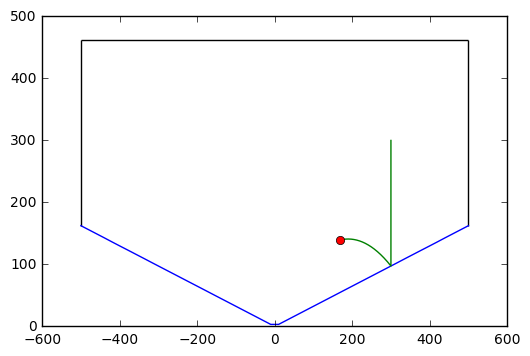

In [49]:
fric = fricV2
s = 100
L,d = 10.0*s,3.0*s
mi_dt=0.01
a = alpha[1]
inicio = np.array([3,3,0,0])*100
N=1000
trayectoria=zeros((N,len(inicio)))
trayectoria[0,:]=array(inicio)

roof = d+rampa(L/2,a)
wall = L/2
for i in range(N-1):
    t,sol = int_rk4(ec_mov,trayectoria[i,:],[0,mi_dt],fric=0.0)
    y = sol[-1,:]
    # condicion piso
    yr = rampa(sol[-1][0],a)
    if y[1] < yr: 
        y = rebote_rampa(trayectoria[i,:],mi_dt,a,tol=1e-2)
    # condicion techo
    elif y[1] > roof:
        y = rebote_techo(trayectoria[i,:],mi_dt,roof,tol=1e-2)    
    # condicion paredes
    if abs(y[0]) > wall :
        y = rebote_pared(trayectoria[i,:],mi_dt,wall,tol=1e-2)
    trayectoria[i+1,:] = y
        
x = np.linspace(-L/2,L/2)
plt.plot(x,rampa(x,a))
plt.hlines(d+rampa(L/2,a),-L/2,L/2)
plt.vlines([-L/2,L/2],rampa(L/2,a),rampa(L/2,a)+d)


plt.plot(trayectoria[:,0],trayectoria[:,1],'-')
plt.plot(trayectoria[-1,0],trayectoria[-1,1],'o')